In [1]:
import pandas as pd
import os
import re

from geopy.geocoders import Nominatim
# from transformers import BertTokenizer, BertModel
from tqdm.notebook import tqdm

import torch
import torch.nn as nn

from torch.optim import Adam

from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertTokenizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import f1_score, accuracy_score

import sys
sys.path.append('../')

from datasets import CoordinatesRegressionDataset
from models import BertRegressionModelBase
from utils import encode_norm_lat, encode_norm_long, decode_norm_lat, decode_norm_long, MAE_km

In [2]:
data = pd.read_csv('../data/geotexts_data_clean.csv')

C:\Users\kazza\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
data['norm_latitude'] = data['latitude'].apply(encode_norm_lat)
data['norm_longitude'] = data['longitude'].apply(encode_norm_long)

In [4]:
#use multilingual bert
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
encoder = BertModel.from_pretrained("bert-base-multilingual-cased")
encoder.load_state_dict(torch.load("bert_country_encoder2.pt"))

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [5]:
data = data.dropna(subset=['country'])
data = data[data['country'] != 'NaN']
print(data.shape)
train_data, val_data = train_test_split(data, test_size = 0.05, stratify=data['country'], shuffle=True, random_state=42)

train_dataset = CoordinatesRegressionDataset(train_data, 'text', latitude_col='norm_latitude', longitude_col='norm_longitude')
train_dataloader = DataLoader(train_dataset, batch_size = 32)

val_dataset = CoordinatesRegressionDataset(val_data, 'text', latitude_col='norm_latitude', longitude_col='norm_longitude')
val_dataloader = DataLoader(val_dataset, batch_size = 64)

(3075246, 10)


In [6]:
model = BertRegressionModelBase(encoder, tokenizer)

In [7]:
#Let's try classicc Adam optimizer
# optimizer = Adam([{'params': model.bert_model.parameters(), 'lr': 1e-5},
#                   {'params': model.mlp.parameters(), 'lr': 1e-3}])

#Let's try grradient dropout AdamW optimizer for tuning bert, 
#for mlp-part it will work as default AdamW
from ChildTuning.ChildTuningOptimizer import ChildTuningAdamW 
optimizer = ChildTuningAdamW([{'params': model.bert_model.parameters(), 'lr': 1e-5, 'reserve_p': 0.5},
                            {'params': model.mlp.parameters(), 'lr': 1e-3, 'reserve_p': 1.0}])


epochs = 200
device = torch.device('cuda')

51480


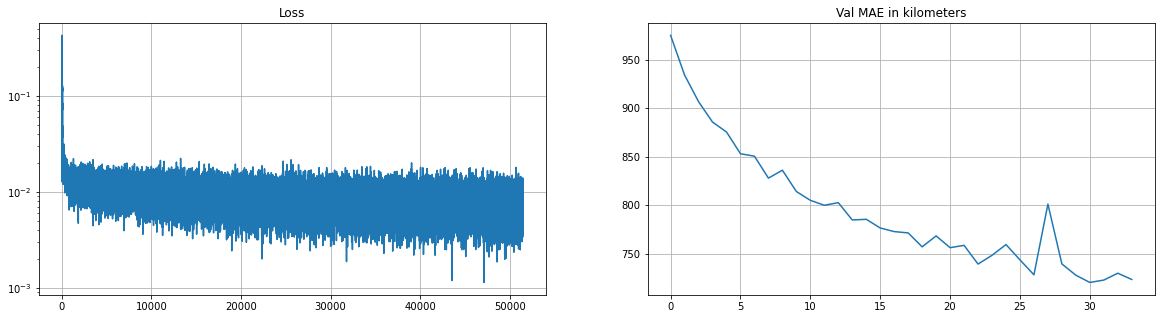

KeyboardInterrupt: 

In [8]:
losses = []
mae = []
for epoch in range(epochs):
    for i, batch in enumerate(train_dataloader):

        logits = model.forward(batch[0])
        labels = torch.stack(batch[1], -1).to(device)
        loss = nn.MSELoss()(logits, labels)
        
        loss.backward()

        #feel lack of memory, so I use gradient accumulation
        if i % 20 == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        losses.append(loss.item())

        if (i % 1500 == 0)&(i != 0):
            summa = 0
            n = 0
            print('######### Calculate validation ########')
            with torch.no_grad():
                for j, val_batch in enumerate(val_dataloader):
                    if j % 20 == 0:
                        clear_output()
                        print('Val ', j)
                    logits = model.forward(val_batch[0]).cpu().numpy()
                    labels = torch.stack(val_batch[1], -1).numpy()
                    for coords1, coords2 in zip(logits, labels):
                        decoded_coords1 = (decode_norm_lat(coords1[0]), decode_norm_long(coords1[1]))
                        decoded_coords2 = (decode_norm_lat(coords2[0]), decode_norm_long(coords2[1]))
                        summa += MAE_km(decoded_coords1, decoded_coords2)
                        n += 1
            mae.append(summa/n)
            print(mae)
            torch.save(model.state_dict(), '../data/geomodeldefault.pt')

        if i % 20 == 0:
            clear_output()
            print(i)
            plt.figure(figsize=(20,5))
            plt.subplot(121)
            plt.semilogy(losses)
            plt.title('Loss')
            plt.grid(True)
            plt.subplot(122)
            plt.plot(mae)
            plt.title('Val MAE in kilometers')
            plt.grid(True)
            plt.show()
        

In [9]:
#minimal vae in km
import numpy as np
print(np.min(mae))

720.4734393488573
